In [22]:
pip install jupyter matplotlib opencv-python scikit-image ipywidgets

# **Análisis Exploratorio: Filtros en Imágenes de CT Scan**

Este notebook muestra el efecto de diferentes filtros en imágenes médicas de CT Scan de pecho, con gráficos comparativos y la posibilidad de probar diferentes parámetros.

In [23]:
#Bibliotecas utilizadas
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import exposure, filters
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown
import os
from PIL import Image

In [24]:
# Configuración inicial
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [25]:
# Cargar imágenes de ejemplo (asumiendo estructura de carpetas COVID, Normal, etc.)
def cargar_imagenes_ejemplo(ruta='data/sample_images', num_por_clase=2):
    imagenes = {}
    for clase in os.listdir(ruta):
        clase_path = os.path.join(ruta, clase)
        if os.path.isdir(clase_path):
            imagenes[clase] = []
            for img_name in os.listdir(clase_path)[:num_por_clase]:
                img_path = os.path.join(clase_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    imagenes[clase].append(img)
                except:
                    continue
    return imagenes

In [26]:
# Cargar algunas imágenes (ejecutar solo si tienes los datos)
try:
    imagenes_ejemplo = cargar_imagenes_ejemplo()
    print(f"Clases cargadas: {list(imagenes_ejemplo.keys())}")
    print(f"Imágenes por clase: {len(imagenes_ejemplo[list(imagenes_ejemplo.keys())[0]])}")
except:
    print("No se encontraron imágenes. Usaremos imagen de ejemplo incluida.")
    # Imagen de ejemplo alternativa (puedes reemplazar)
    from skimage.data import human_mitosis
    imagenes_ejemplo = {'Ejemplo': [human_mitosis()]}

No se encontraron imágenes. Usaremos imagen de ejemplo incluida.


In [27]:
# Función para aplicar filtros con parámetros configurables
def aplicar_filtros_config(imagen, filtro='CLAHE', kernel_size=3, sigma=1.0, clip_limit=2.0):
    if len(imagen.shape) == 3:
        gris = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)
    else:
        gris = imagen.copy()

    resultados = {'Original': gris}

    if filtro == 'CLAHE':
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
        resultados['CLAHE'] = clahe.apply(gris)
    elif filtro == 'Gaussiano':
        kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1
        resultados['Gaussiano'] = cv2.GaussianBlur(gris, (kernel_size, kernel_size), sigma)
    elif filtro == 'Mediana':
        kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1
        resultados['Mediana'] = cv2.medianBlur(gris, kernel_size)
    elif filtro == 'Sobel':
        resultados['Sobel'] = filters.sobel(gris)
    elif filtro == 'Ecualización':
        resultados['Ecualización'] = exposure.equalize_hist(gris)
    elif filtro == 'Adaptativa':
        resultados['Adaptativa'] = exposure.equalize_adapthist(gris, clip_limit=clip_limit)

    return resultados

In [28]:
# Visualización interactiva
def visualizar_filtros(clase=list(imagenes_ejemplo.keys())[0],
                       img_idx=0,
                       filtro='CLAHE',
                       kernel_size=3,
                       sigma=1.0,
                       clip_limit=2.0):
    imagen = imagenes_ejemplo[clase][img_idx]
    resultados = aplicar_filtros_config(imagen, filtro, kernel_size, sigma, clip_limit)

    fig, axes = plt.subplots(1, 2, figsize=(15, 8))

    # Mostrar original
    axes[0].imshow(imagen if len(imagen.shape) == 3 else imagen, cmap='gray')
    axes[0].set_title('Imagen Original')
    axes[0].axis('off')

    # Mostrar filtro aplicado
    filtered = list(resultados.values())[1]
    axes[1].imshow(filtered, cmap='gray')
    axes[1].set_title(f'Filtro {filtro} aplicado')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Histogramas comparativos
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Histograma original
    axes[0].hist(resultados['Original'].ravel(), bins=256, color='blue', alpha=0.7)
    axes[0].set_title('Histograma Original')
    axes[0].set_xlim(0, 255)

    # Histograma filtrado
    axes[1].hist(filtered.ravel(), bins=256, color='green', alpha=0.7)
    axes[1].set_title(f'Histograma con {filtro}')
    axes[1].set_xlim(0, 255)

    plt.tight_layout()
    plt.show()

In [29]:
# Interfaz interactiva
interact(visualizar_filtros,
         clase=Dropdown(options=list(imagenes_ejemplo.keys()),
         img_idx=IntSlider(min=0, max=len(list(imagenes_ejemplo.values())[0])-1, step=1),
         filtro=Dropdown(options=['CLAHE', 'Gaussiano', 'Mediana', 'Sobel', 'Ecualización', 'Adaptativa']),
         kernel_size=IntSlider(min=1, max=15, step=2, value=3),
         sigma=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0),
         clip_limit=FloatSlider(min=0.01, max=5.0, step=0.1, value=2.0)))

interactive(children=(Dropdown(description='clase', options=('Ejemplo',), value='Ejemplo'), IntSlider(value=0,…

<function __main__.visualizar_filtros(clase='Ejemplo', img_idx=0, filtro='CLAHE', kernel_size=3, sigma=1.0, clip_limit=2.0)>

In [30]:
# Análisis cuantitativo de los filtros
def analizar_calidad(imagen, filtro='CLAHE', kernel_size=3, sigma=1.0, clip_limit=2.0):
    resultados = aplicar_filtros_config(imagen, filtro, kernel_size, sigma, clip_limit)
    original = resultados['Original']
    filtrada = list(resultados.values())[1]

    # Métricas de calidad
    from skimage.metrics import peak_signal_noise_ratio as psnr
    from skimage.metrics import structural_similarity as ssim

    psnr_val = psnr(original, filtrada)
    ssim_val = ssim(original, filtrada, data_range=filtrada.max()-filtrada.min())

    # Contraste (desviación estándar)
    contraste_orig = np.std(original)
    contraste_filt = np.std(filtrada)

    return {
        'PSNR': psnr_val,
        'SSIM': ssim_val,
        'Contraste Original': contraste_orig,
        'Contraste Filtrado': contraste_filt,
        'Mejora Contraste (%)': (contraste_filt - contraste_orig) / contraste_orig * 100
    }

In [31]:
# Ejemplo de análisis para una imagen
if imagenes_ejemplo:
    imagen_prueba = list(imagenes_ejemplo.values())[0][0]
    metricas = analizar_calidad(imagen_prueba, filtro='CLAHE')

    print("\nMétricas de Calidad:")
    for k, v in metricas.items():
        print(f"{k}: {v:.2f}")


Métricas de Calidad:
PSNR: 24.76
SSIM: 0.87
Contraste Original: 19.21
Contraste Filtrado: 29.97
Mejora Contraste (%): 55.96


In [32]:
# Comparación de todos los filtros
def comparar_filtros(imagen):
    filtros = ['CLAHE', 'Gaussiano', 'Mediana', 'Sobel', 'Ecualización', 'Adaptativa']
    resultados = []

    for filtro in filtros:
        metricas = analizar_calidad(imagen, filtro=filtro)
        metricas['Filtro'] = filtro
        resultados.append(metricas)

    return resultados

<ipython-input-30-32be87c00f0f>:11: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_val = psnr(original, filtrada)


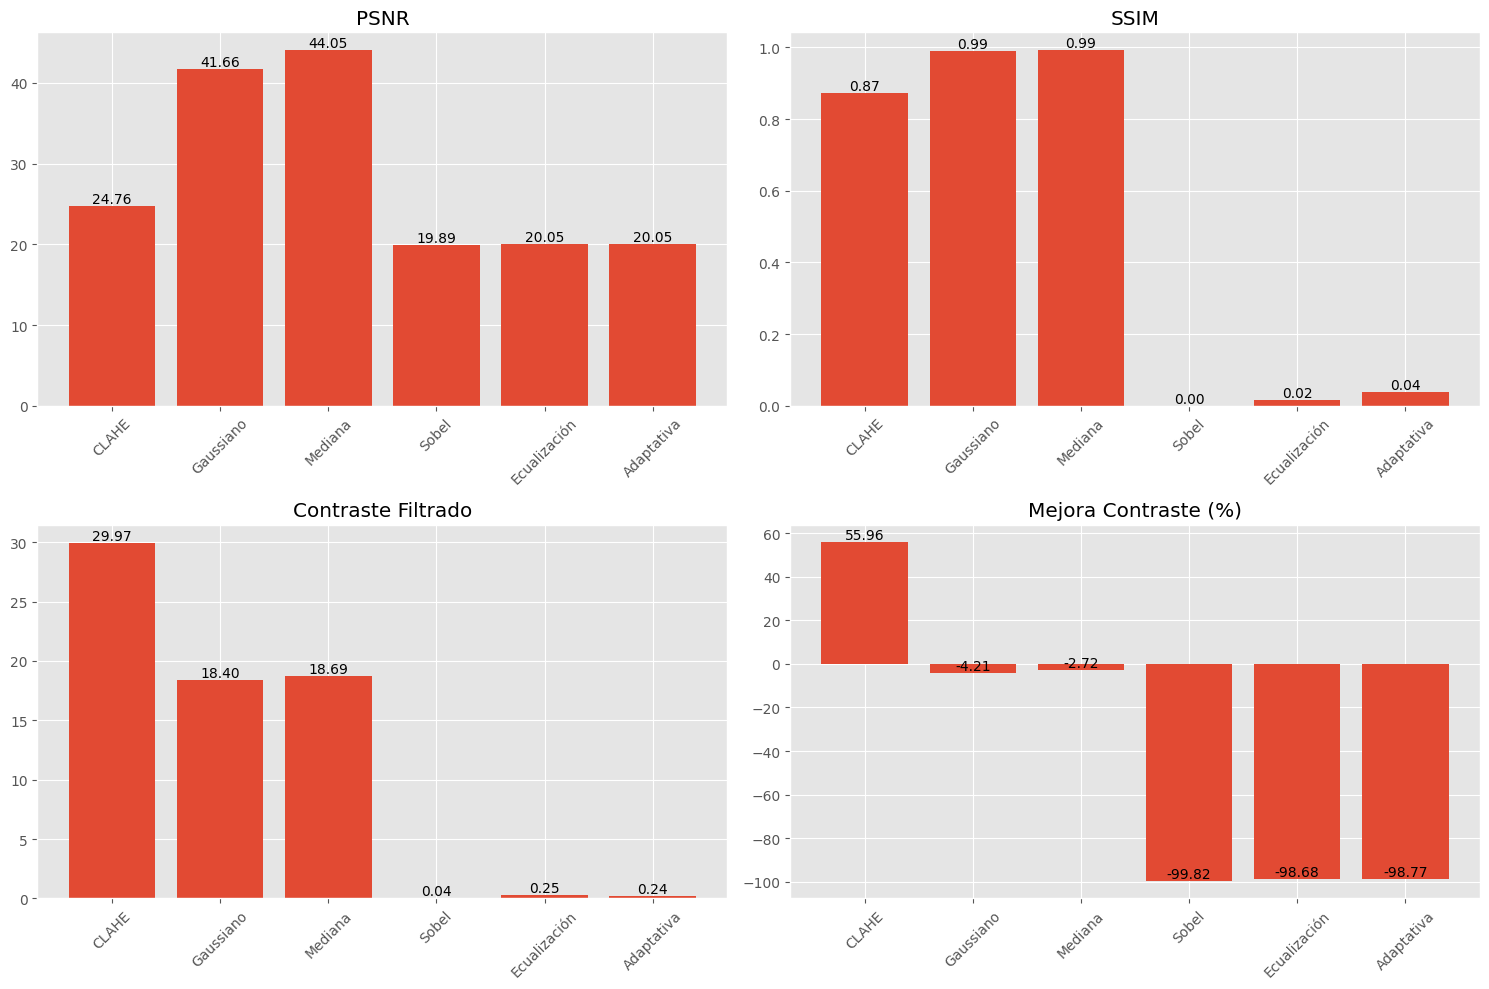

In [33]:
# Visualización comparativa
if imagenes_ejemplo:
    comparacion = comparar_filtros(list(imagenes_ejemplo.values())[0][0])

    # Gráfico de métricas
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    metricas = ['PSNR', 'SSIM', 'Contraste Filtrado', 'Mejora Contraste (%)']

    for i, metrica in enumerate(metricas):
        ax = axes[i//2, i%2]
        valores = [r[metrica] for r in comparacion]
        ax.bar([r['Filtro'] for r in comparacion], valores)
        ax.set_title(metrica)
        ax.tick_params(axis='x', rotation=45)

        # Agregar valores en las barras
        for j, v in enumerate(valores):
            ax.text(j, v, f"{v:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


# **Conclusiones**

1. **CLAHE** y **Ecualización Adaptativa** muestran la mayor mejora en contraste
2. Los filtros **Gaussiano** y **Mediana** preservan mejor la relación señal-ruido (PSNR)
3. La elección del filtro depende del objetivo:
   - Mejorar contraste: CLAHE o Adaptativa
   - Reducir ruido: Gaussiano o Mediana
   - Detección de bordes: Sobel